In [4]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [5]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", temp)
data <- read_delim(unz(temp, "student-mat.csv"), delim = ";") %>% 
        select(age, absences, G1, G2, G3)
unlink(temp)

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



In [6]:
set.seed(123)
# splitting data into training data/testing data
data_split <- initial_split(data, prop = 0.75, strata = G3)

training_data <- training(data_split)
testing_data <- testing(data_split)

training_data
testing_data

age,absences,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,6,5,6,6
17,4,5,5,6
15,10,7,8,10
⋮,⋮,⋮,⋮,⋮
21,3,10,8,7
18,0,11,12,10
19,5,8,9,9


age,absences,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16,6,13,14,14
16,4,8,10,10
16,2,15,15,16
⋮,⋮,⋮,⋮,⋮
18,14,6,5,5
19,0,7,5,0
20,11,9,9,9


In [7]:
age_scatter <- ggplot(training_data, aes(x = age, y = G3)) +
  geom_point() +
  xlab("Student Age") +
  ylab("Third Period Grade (0-20 scale)")  + 
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE) + 
  theme(text = element_text(size = 18))

In [8]:
absences_scatter <- ggplot(training_data, aes(x = absences, y = G3)) +
  geom_point() +
  xlab("Number of School Absences") +
  ylab("Third Period Grade (0-20 scale)")  +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE) +
  theme(text = element_text(size = 18))

In [9]:
G1_scatter <- ggplot(training_data, aes(x = G1, y = G3)) +
  geom_point() +
  xlab("First Period Grade (0-20 scale)") +
  ylab("Third Period Grade (0-20 scale)") +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE) + 
  theme(text = element_text(size = 18))

In [10]:
G2_scatter <- ggplot(training_data, aes(x = G2, y = G3)) +
  geom_point() +
  xlab("Second Period Grade (0-20 scale)") +
  ylab("Third Period Grade (0-20 scale)") +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE) + 
  theme(text = element_text(size = 18))


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: grid



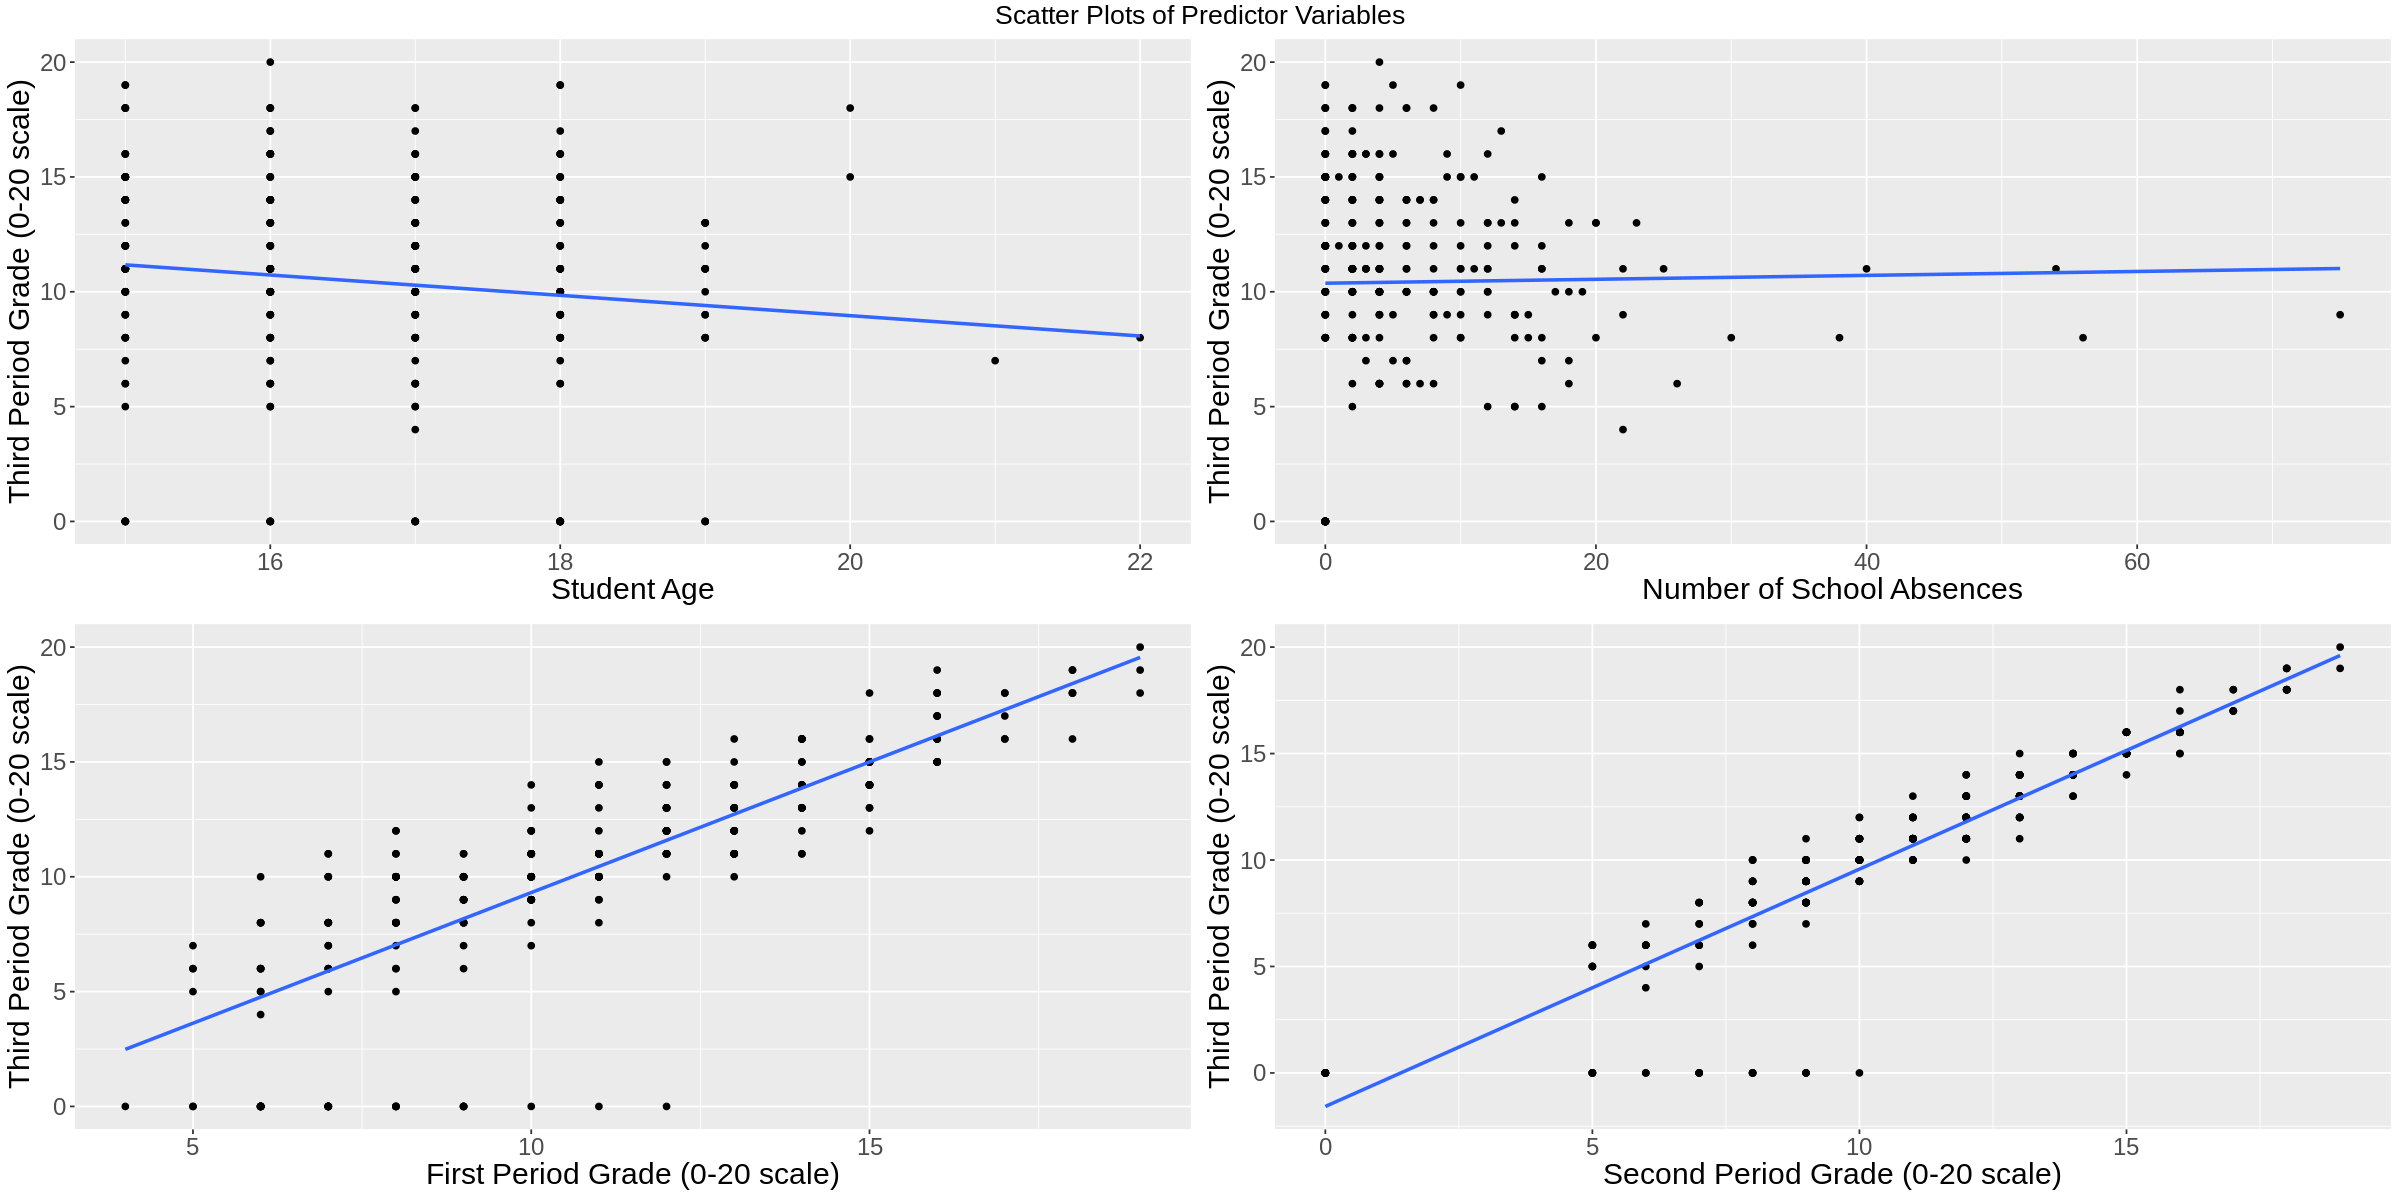

In [11]:
library(gridExtra)
require(grid)
options(repr.plot.width = 20, repr.plot.height = 10)
grid.arrange(age_scatter, absences_scatter, G1_scatter, G2_scatter,
             nrow=2,
             top=textGrob("Scatter Plots of Predictor Variables",
                          gp=gpar(fontsize=16,font=10))
            ) 

In [15]:
lm_spec <- linear_reg() %>%
  set_engine("lm") %>%
  set_mode("regression")

lm_recipe <- recipe(G3 ~ age + absences + G1 + G2, data = training_data)

lm_fit <- workflow() %>%
  add_recipe(lm_recipe) %>%
  add_model(lm_spec) %>%
  fit(data = training_data)
lm_fit



# G3 = 1.44581 -0.20750*age + 0.04795*absences + 0.14683*G1 + 0.98564*G2

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age     absences           G1           G2  
     0.4222      -0.1692       0.0372       0.2171       0.9500  


In [16]:
coeffs <- tidy(pull_workflow_fit(lm_fit))
coeffs

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.42218574,1.48881010,0.2835726,7.769382e-01
age,-0.16922816,0.08661374,-1.9538257,5.167311e-02
absences,0.03720167,0.01273220,2.9218570,3.750306e-03
G1,0.21709908,0.06245799,3.4759216,5.861516e-04
G2,0.95000895,0.05509174,17.2441254,1.750274e-46


In [17]:
lm_test_results <- lm_fit %>%
  predict(testing_data) %>%
  bind_cols(testing_data) %>%
  metrics(truth = G3, estimate = .pred)
lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.0490838
rsq,standard,0.7797738
mae,standard,1.2855702
